목표

---

1. 비디오클립을 읽고 음원만 따로 분리한다.

2. 음원을 Whisper를 통해 Text화 한다.

3. 세그먼트 단위로 문장을 넣어GPT/LLaMa 를 통해 요약을 해보라고 한다

4. 해당 세그먼트에 대한 시간동안 Object Detction or Segmentation 를 수행해본다.

In [1]:
import whisper

import numpy as np

from glob import glob

In [37]:
import pandas as pd

original_pd = pd.read_excel('../dataset.xlsx', sheet_name='Original')

## 영상 파형 출력

In [2]:
import torch
import torchaudio

file_path = "../OR-YO-VI-1.mp3"
data, sr = torchaudio.load(file_path)

In [3]:
print(data.shape, sr, data.shape[1] / sr)

torch.Size([2, 72832032]) 44100 1651.52


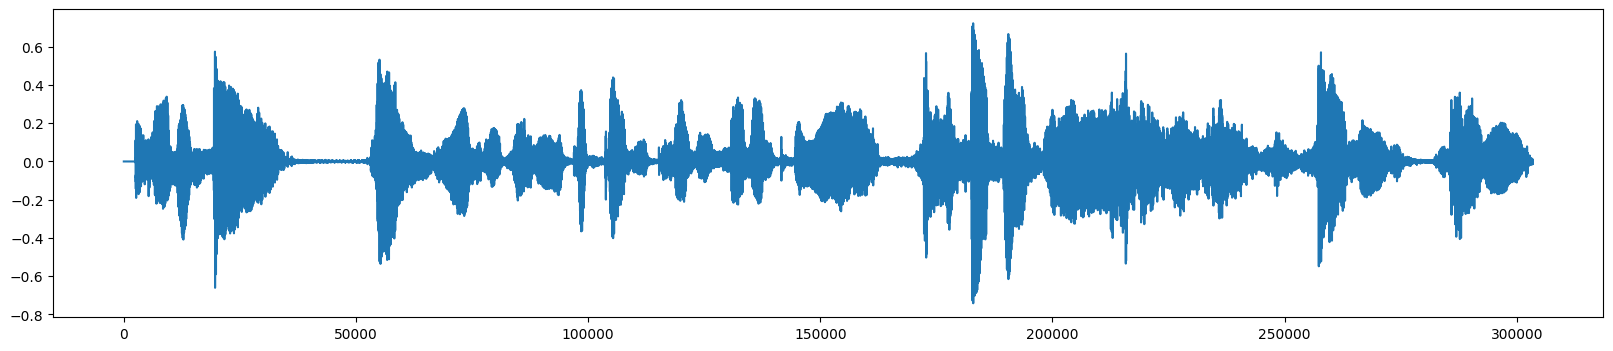

In [5]:
from matplotlib import pyplot as plt

_, ax = plt.subplots(1, 1, figsize=(20, 4))
ax.plot(data[0, :data.shape[1]//240])
plt.show()

## 음원 데이터 EDA

In [23]:
import json
import numpy as np

from matplotlib import pyplot as plt

script = json.load(open("../OR-YO-VI-1.json", "r"))


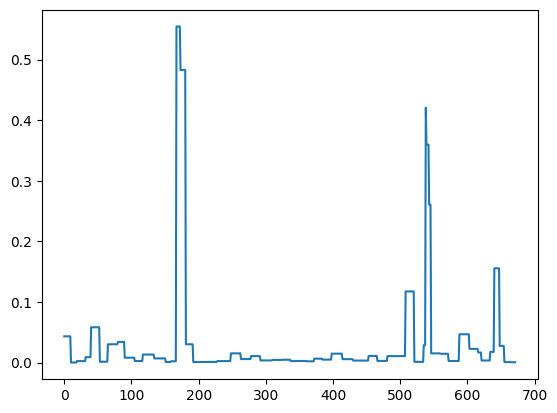

In [24]:
### no_speech_prob 비율?

no_speech_probs = np.array([segment['no_speech_prob'] for segment in script['segments']])

plt.plot(no_speech_probs)
plt.show()

In [20]:
np.where(no_speech_probs > 0.5) # 0.5 이성인 부분

(array([167, 168, 169, 170, 171, 172]),)


In [26]:
np.where((no_speech_probs > 0.1) & (no_speech_probs < 0.2)) # 0.1 ~ 0.2 사이인 부분

(array([508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520,
        640, 641, 642, 643, 644, 645, 646, 647]),)

In [27]:
script['segments'][512]

{'id': 512,
 'seek': 109336,
 'start': 1105.74,
 'end': 1107.74,
 'text': ' 숙소에서도 방에 혼자가 아니라',
 'tokens': [50984,
  3471,
  247,
  12012,
  40963,
  10006,
  1517,
  31523,
  22310,
  22948,
  51084],
 'temperature': 0.4,
 'avg_logprob': -0.5395548893855169,
 'compression_ratio': 1.6377952755905512,
 'no_speech_prob': 0.1174200102686882}

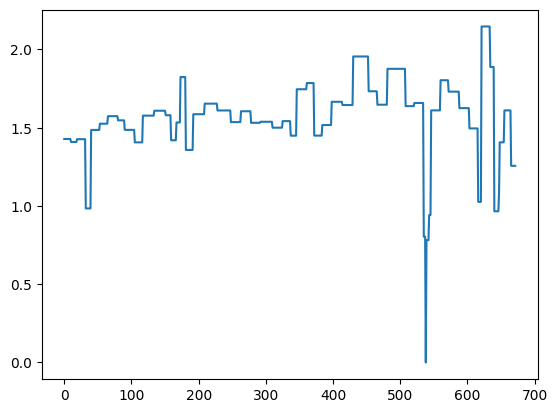

In [29]:
compression_ratios = np.array([segment['compression_ratio'] for segment in script['segments']])
plt.plot(compression_ratios)
plt.show()

In [33]:
np.where(compression_ratios < 0.95)

(array([535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545]),)

In [35]:
script['segments'][536]

{'id': 535,
 'seek': 115336,
 'start': 1153.36,
 'end': 1155.36,
 'text': ' 너무 답답했어',
 'tokens': [50365, 6924, 41918, 23884, 36756, 50465],
 'temperature': 0.0,
 'avg_logprob': -0.3187368631362915,
 'compression_ratio': 0.8035714285714286,
 'no_speech_prob': 0.028853032737970352}

: 

## 원본 영상에 대한 프롬프트 생성

In [54]:
with open("start_prompt.txt", "w") as f:
    for segment in script['segments']:        
        text = "{" + str(segment['id']) + "}|{" + str(round(segment['start'], 4)) + "}:{" + str(round(segment['end'], 4)) + "}-{" + segment['text'] + "}\n"
        f.write(text)

In [ ]:
### GPT 프롬프트 작성

'''
START_QUESTION
다음은 유튜브 영상의 내용을 텍스트화 했어. 이 유튜브 영상의 제목은 "{TEXT}"이야.
데이터는 segment 단위로 알려줄거고 구조는 {Index}|{START_TIME}:{END_TIME} - {SENTENCE}이야.
텍스트를 보고 어떤 영상인지 요약해줘.
{DATA}...
---------------------------------------------
SPECIFIC_QUESTION
다음 영상에서 등장하는 인물은 누가 있어? 등장인물의 이름과 어떤 주제로 대화하고 있는지 알려줘. 주요 주제들을
{주제}: {자세한 내용}으로 형식화하여 알려줘

다음 영상에서 다루고 있는 소주제는 무엇이 있을까?
    - 영상에서 등장하고 있는 인물과 연관되어서 소주제들을 연결할 수 있을까?
        - 관련된 소주제의 문장 번호를 알려줄 수 있어?
        - 관련된 문장들을 요약해서 최소 3개 최대 5개의 문장으로 목록화 해줄 수 있어?
        - 대화 참여자가 말한 문장을 인용하면서 요약해줄 수 있어?
    - 소주제와 관련해서 연관지을 수 있는 이모티콘을 알려줄래?
        
다음 영상에서 광고에 해당하는 부분이 있을까?

다음 영상은 어떤 형식의 콘텐츠야?

너는 이 영상을 가지고 클립으로 만들어 사람들에게 SNS으로 공유하려고 해. 그럴 때 사용하고자 하는 클립은 어떤 문장과 관련된 장면을 사용할 거 같아?
    - 짧으면 30초 길면 1분 짜리 클립을 만들건데, 여기서 사용할 문장은 몇 번째 문장이야? 문장 번호들을 알려줘

>>>

'''

In [39]:
original_pd.loc[0, 'Original title']

'[SUB] 🔥충격 실화🔥 피아노 치는 김민정 실존❗️ l EP.28 l 조현아의 목요일 밤 l 윈터 에스파 조현아'

In [2]:
pwd

'/home/pengpark/workspace/guacamole/experiment'

## 음원 추출

In [4]:
from moviepy.editor import VideoFileClip
import whisper
import json

clip = VideoFileClip("../dataset/infringement/IR-TI-VI-1.mp4")
clip.audio.write_audiofile("IR-TI-VI-1.mp3")

model = whisper.load_model('large')
res = model.transcribe('IR-TI-VI-1.mp3')

with open("IR-TI-VI-1.json", "w") as f:
    json.dump(res, f)

In [9]:
with open("start_prompt_infringement.txt", "w") as f:
    for segment in res['segments']:        
        text = "{" + str(segment['id']) + "}|{" + str(round(segment['start'], 4)) + "}:{" + str(round(segment['end'], 4)) + "}-{" + segment['text'] + "}\n"
        f.write(text)

## 침해 영상 프롬프트 디자인

In [11]:
import pandas as pd

infringement_pd = pd.read_excel('../dataset.xlsx', sheet_name='Infringement')

In [12]:
infringement_pd.head()

,Infringement ID,Infringement link,Infringement platform,Infringement form,Infringement creator name,Infringement title,Infringement body text,Infringement hashtag,Infringement subscribe,Infringement view,Infringement upload date,Find day
0,IR-TI-VI-1,https://www.tiktok.com/@tuananp3/video/7304108...,_x0008_tiktok,video,tuananp3,NaN,#웃음가득 #유머그램 #유모페이지 #유머짤방 #후하하 하 #치아하하 #짤스타그램 #...,#웃음가득 #유머그램 #유모페이지 #유머짤방 #후하하 하 #치아하하 #짤스타그램 #...,6013.0,78.0,NaT,2023-11-23
1,IR-TI-VI-2,https://www.tiktok.com/@fun_video_button/video...,_x0008_tiktok,video,fun_video_button,서준맘 이수지 멕이는 법,#오늘의버튼 #뻥쿠르트 #손동표 #이수지 #린자오밍 #서준맘 #연애 #웃긴썰 #웃긴...,#오늘의버튼 #뻥쿠르트 #손동표 #이수지 #린자오밍 #서준맘 #연애 #웃긴썰 #웃긴...,23900.0,2043.0,NaT,2023-11-23
2,IR-TI-VI-3,https://www.tiktok.com/@user8445859804246/vide...,_x0008_tiktok,video,user8445859804246,여자 해병대에 있는 똥군기,#여자 #해병대 #군기 #밀크필름 #공감 #스케치코미디 #재미 #유머 #웃긴 #예능...,#여자 #해병대 #군기 #밀크필름 #공감 #스케치코미디 #재미 #유머 #웃긴 #예능...,3240.0,859600.0,NaT,2023-11-23
3,IR-YO-VI-4,https://www.youtube.com/watch?v=wnNV9vP-elk,youtube,video,1분순삭,꼰대희식 영어 발음에 당황한 에일리,#shorts #꼰대희 원본영상은 '꼰대희' 채널에서 보실 수 있습니다😀\n,#shorts #꼰대희,158000.0,10610000.0,2023-10-16,2023-12-03
4,IR-IN-VI-5,https://www.instagram.com/p/C0Jl3tuSJdY/?igshi...,instagram,video,lllll_lllll_llil,첫 문화센터 방문한 유준이..사회생활ㅋㅋ,유준이 미쳤다💕\n출처: 리쥬라이크 LIJULIKE.\n.\n.\n#유준이 #유혜주...,#유준이 #유혜주 #사회생활 #사회 #문화센터 #졸귀 #당근 #좋아요 #유튜브 #댓글,35000.0,NaN,2023-11-27,2023-12-03


In [15]:
infringement_pd

,Infringement ID,Infringement link,Infringement platform,Infringement form,Infringement creator name,Infringement title,Infringement body text,Infringement hashtag,Infringement subscribe,Infringement view,Infringement upload date,Find day
0,IR-TI-VI-1,https://www.tiktok.com/@tuananp3/video/7304108...,_x0008_tiktok,video,tuananp3,NaN,#웃음가득 #유머그램 #유모페이지 #유머짤방 #후하하 하 #치아하하 #짤스타그램 #...,#웃음가득 #유머그램 #유모페이지 #유머짤방 #후하하 하 #치아하하 #짤스타그램 #...,6013.0,78.0,NaT,2023-11-23
1,IR-TI-VI-2,https://www.tiktok.com/@fun_video_button/video...,_x0008_tiktok,video,fun_video_button,서준맘 이수지 멕이는 법,#오늘의버튼 #뻥쿠르트 #손동표 #이수지 #린자오밍 #서준맘 #연애 #웃긴썰 #웃긴...,#오늘의버튼 #뻥쿠르트 #손동표 #이수지 #린자오밍 #서준맘 #연애 #웃긴썰 #웃긴...,23900.0,2043.0,NaT,2023-11-23
2,IR-TI-VI-3,https://www.tiktok.com/@user8445859804246/vide...,_x0008_tiktok,video,user8445859804246,여자 해병대에 있는 똥군기,#여자 #해병대 #군기 #밀크필름 #공감 #스케치코미디 #재미 #유머 #웃긴 #예능...,#여자 #해병대 #군기 #밀크필름 #공감 #스케치코미디 #재미 #유머 #웃긴 #예능...,3240.0,859600.0,NaT,2023-11-23
3,IR-YO-VI-4,https://www.youtube.com/watch?v=wnNV9vP-elk,youtube,video,1분순삭,꼰대희식 영어 발음에 당황한 에일리,#shorts #꼰대희 원본영상은 '꼰대희' 채널에서 보실 수 있습니다😀\n,#shorts #꼰대희,158000.0,10610000.0,2023-10-16,2023-12-03
4,IR-IN-VI-5,https://www.instagram.com/p/C0Jl3tuSJdY/?igshi...,instagram,video,lllll_lllll_llil,첫 문화센터 방문한 유준이..사회생활ㅋㅋ,유준이 미쳤다💕\n출처: 리쥬라이크 LIJULIKE.\n.\n.\n#유준이 #유혜주...,#유준이 #유혜주 #사회생활 #사회 #문화센터 #졸귀 #당근 #좋아요 #유튜브 #댓글,35000.0,NaN,2023-11-27,2023-12-03
5,IR-IN-VI-6,https://www.instagram.com/p/Cw-HtyqSKoh/,instagram,video,shinez_fim,채채의 앞머리를 입수시킨 그것의 정체는???,채원이가 끝까지 지킨 앞머리를 입수시킨 그것?!\n-\n-\n#LE_SSERAFIM...,#LE_SSERAFIM #르세라핌 #허윤진 #카즈하 #사쿠라 #홍은채 #김채원 #s...,265.0,14700.0,2023-09-09,2023-12-04
6,IR-YO-VI-7,https://www.youtube.com/watch?v=_VgmSfgxlvo,youtube,video,1분순삭,여동생이 자꾸 나를 변태로 오해한다,#웃기시네 #shorts\n#shorts #웃기시네\n출처 : \n\n • 여...,#웃기시네 #shorts\n#shorts #웃기시네,159000.0,10323318.0,2023-08-14,2023-12-05
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT


In [16]:
infringement_pd.loc[0, "Infringement body text"]

'#웃음가득 #유머그램 #유모페이지 #유머짤방 #후하하 하 #치아하하 #짤스타그램 #웃긴 #웃긴 #미소 #공 감 #웃긴 #스위트잼 #빅펀 #유머 #계속웃어봐 #웃 음스타그램 #웃음 닥치고 #재미있게보면서 #힐링데 이 #핵공감'

In [17]:
infringement_pd.loc[0, "Infringement hashtag"]

'#웃음가득 #유머그램 #유모페이지 #유머짤방 #후하하 하 #치아하하 #짤스타그램 #웃긴 #웃긴 #미소 #공 감 #웃긴 #스위트잼 #빅펀 #유머 #계속웃어봐 #웃 음스타그램 #웃음 닥치고 #재미있게보면서 #힐링데 이 #핵공감'

In [ ]:
'''
다음은 SNS에서 공유되고 있는 어떤 유튜브 영상이야. 이 영상의 제목은 {TEXT}이야.
데이터는 segment 단위로 알려줄거고 구조는 {START_TIME}:{END_TIME} - {SENTENCE}이야.
텍스트를 보고 어떤 영상인지 요약해줘.
-----------

해당 영상의 내용으로 유튜브에서 참조한 출처를 찾고 싶어. 어떤 키워드를 가지고 검색하면 찾을 수 있을까?
    - 영상에서 언급한 단어를 가지고 키워드를 조합해줄 수 있어?
    - 영상의 제목과 언급한 단어를 가지고 키워드를 조합해줄 수 있어?

영상 내용을 가지고 등장인물은 누가 있는지 어떤 상황일지 상상해볼래?

'''

# 군 입대 할 뻔한 에스파 윈터 ㄷㄷㄷ